# Checks

Objectives:

* Check if the implicit velocity operator $A$ is symmetric positive-definite.
* Check if there is any advantage in formulating the operators such that $D = -G^T$ and $H f = -E^T \tilde{f}$.

In [1]:
import math
import numpy
from scipy.sparse import csr_matrix, hstack, identity

import pyibm

from helper import plot_contourf

In [2]:
%matplotlib inline

In [3]:
pyibm.__version__

'0.1'

## Create stretched Cartesian grids

In [4]:
# Set parameters of the computational grid.
xlim, ylim = (-15.0, 15.0), (-15.0, 15.0)  # domain limits
xbox, ybox = (-0.75, 0.75), (-0.75, 0.75)  # uniform region
dx, dy = 0.05, 0.05  # grid spacings in the uniform region

config_x = [dict(start=xlim[0], end=xbox[0],
                 width=dx, stretching=1.03, reverse=True),
            dict(start=xbox[0], end=xbox[1], width=dx),
            dict(start=xbox[1], end=xlim[1],
                 width=dx, stretching=1.01)]

config_y = [dict(start=ylim[0], end=ybox[0],
                 width=dy, stretching=1.04, reverse=True),
            dict(start=ybox[0], end=ybox[1], width=dy),
            dict(start=ybox[1], end=ylim[1],
                 width=dy, stretching=1.04)]

config = {'x': dict(start=xlim[0], segments=config_x),
          'y': dict(start=ylim[0], segments=config_y)}

# Uncomment the following three lines when testing.
# config = dict(x=dict(start=-2.0, end=2.0, num_cells=20),
#               y=dict(start=-2.0, end=2.0, num_cells=20))
# dx, dy = 4.0 / 20, 4.0 / 20

# Create staggered grids.
grid = pyibm.GridBase(config=config)  # vertex grid
gridc = pyibm.GridCellCentered(grid=grid)  # cell-centered grid
gridx = pyibm.GridFaceX(grid=grid)  # x-face centered grid
gridy = pyibm.GridFaceY(grid=grid)  # y-face centered grid
print(gridc)
print(gridx)
print(gridy)

Grid(size=38078, shape=(158, 241), gridlines=[
Gridline(start=-15.0, end=15.0, size=241),
Gridline(start=-15.0, end=15.0, size=158)])
Grid(size=37920, shape=(158, 240), gridlines=[
Gridline(start=-15.0, end=15.0, size=240),
Gridline(start=-15.0, end=15.0, size=158)])
Grid(size=37837, shape=(157, 241), gridlines=[
Gridline(start=-15.0, end=15.0, size=241),
Gridline(start=-15.0, end=15.0, size=157)])


## Assemble operators

In [5]:
# Assemble non-normalized gradient operator.
GHat = pyibm.assemble_GHat(gridc, gridx, gridy)
pyibm.print_matrix_info(GHat, name='GHat')

# Assemble non-normalized divergence operator.
DHat = pyibm.assemble_DHat(gridc, gridx, gridy)
pyibm.print_matrix_info(DHat, name='DHat')

Name:  GHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 38078)
Size:  151514
Min/Max:  -20.00000000000003 20.00000000000003
Name:  DHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (38078, 75757)
Size:  151514
Min/Max:  -0.5965515242499322 0.5965515242499322


In [6]:
# Assemble diagonal scaling operators.
MHat = pyibm.assemble_MHat(gridx, gridy)
R = pyibm.assemble_R(gridx, gridy)
RInv = pyibm.diagonal_inv(R)

# $M = \hat{M} R^{-1}$ (Taira & Colonius, 2007).
M = MHat @ RInv

In [7]:
# Normalize gradient and divergence operators.
# $G = \hat{M} \hat{G}$ (Taira & Colonius, 2007).
G = MHat @ GHat
pyibm.print_matrix_info(G, name='G')
# $D = \hat{D} R^{-1}$ (Taira & Colonius, 2007).
D = DHat @ RInv
pyibm.print_matrix_info(D, name='D')

# Divergence should be the opposite transposed gradient.
K = D + G.T
K = K.multiply(abs(K) > 1e-15) # remove extremely small values
pyibm.print_matrix_info(K, name='D + G^T')

Name:  G
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 38078)
Size:  151514
Min/Max:  -1.0 1.0
Name:  D
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (38078, 75757)
Size:  151514
Min/Max:  -1.0 1.0
Name:  D + G^T
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (38078, 75757)
Size:  0


Indeed, we have $D = -G^T$ with their elements equal to $+1$ or $-1$.

## Assemble delta operator

In [8]:
def circle(radius=0.5, center=(0.0, 0.0), ds=0.1, phi=0.0):
    """Compute uniformly distributed coordinates on circle."""
    xc, yc = center
    N = math.ceil(2 * math.pi * radius / ds)
    theta = numpy.linspace(0.0, 2 * math.pi, num=N + 1)[:-1] + phi
    x = xc + radius * numpy.cos(theta)
    y = yc + radius * numpy.sin(theta)
    return x, y

In [9]:
# Create an immersed boundary.
body = pyibm.Body(*circle(ds=dx), grid=gridc)
body

Body(ndim=2, size=63)

In [10]:
# Set the delta kernel to use and its size.
delta_kernel = pyibm.delta_roma_et_al_1999
delta_kernel_size = 2

In [11]:
# Assemble the delta operator.
Op = pyibm.assemble_delta(body, gridc, gridx, gridy,
                          kernel=delta_kernel,
                          kernel_size=delta_kernel_size)
pyibm.print_matrix_info(Op, name='Delta')

Name:  Delta
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 75757)
Size:  1122
Min/Max:  5.423461406350576e-07 177.75685547777775


In [12]:
# Assemble interpolation operator as in Taira & Colonius (2007).
alpha = dx * dy
EHat = alpha * Op
pyibm.print_matrix_info(EHat, name='EHat (TC2007)')

# Assemble normalized interpolation (Taira & Colonius, 2007).
E = EHat @ RInv
pyibm.print_matrix_info(E, name='E (TC2007)')

# Assemble interpolation operator as in decoupled IBPM of PetIBM.
EHat2 = Op @ R @ MHat
pyibm.print_matrix_info(EHat2, name='EHat (PetIBM)')

# Check the two operators are the same.
assert numpy.all((EHat - EHat2).data < 1e-12)

Name:  EHat (TC2007)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 75757)
Size:  1122
Min/Max:  1.3558653515876443e-09 0.44439213869444444
Name:  E (TC2007)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 75757)
Size:  1122
Min/Max:  2.7117307031752892e-08 8.8878427738889
Name:  EHat (PetIBM)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 75757)
Size:  1122
Min/Max:  1.355865351587645e-09 0.44439213869444516


In [13]:
# Assemble spreading operator (Taira & Colonius, 2007).
p1, p2 = (body.x[0], body.y[0]), (body.x[1], body.y[1])
ds = math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
beta = ds
HHat = beta / alpha * csr_matrix(EHat.T)
pyibm.print_matrix_info(HHat, name='HHat (TC2007)')

# $H = \hat{M} \hat{H}$ (Taira & Colonius, 2007).
H = MHat @ HHat
pyibm.print_matrix_info(H, name='H (TC2007)')

# Assemble spreading operator as in decoupled IBPM of PetIBM.
# (Note: surface area of markers are absorbed in the unknown.)
HHat2 = csr_matrix(Op.T)
pyibm.print_matrix_info(HHat2, name='HHat (PetIBM)')

Name:  HHat (TC2007)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 126)
Size:  1122
Min/Max:  2.7033723714615463e-08 8.86044789355038
Name:  H (TC2007)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 126)
Size:  1122
Min/Max:  1.3516861857307743e-09 0.44302239467751936
Name:  HHat (PetIBM)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 126)
Size:  1122
Min/Max:  5.423461406350576e-07 177.75685547777775


In [14]:
# Check that the velocity is correctly interpolated onto the boundary.
a, b = 2.2, -1.1
ux = a * numpy.ones(gridx.size)
uy = b * numpy.ones(gridy.size)
u = numpy.concatenate((ux, uy))

U = EHat @ u
Ux, Uy = U[::body.ndim], U[1::body.ndim]

assert numpy.all(Ux - a < 1e-12)
assert numpy.all(Uy - b < 1e-12)

In [15]:
# Check total Lagrangian forces is conserved after spreading.
a, b = 2.2, -1.1
Fx = a * numpy.ones(body.size)
Fy = b * numpy.ones(body.size)
F = numpy.empty(body.ndim * body.size)
F[::body.ndim], F[1::body.ndim] = Fx, Fy

f = HHat @ F
fx, fy = f[:gridx.size], f[gridx.size:]

assert abs(numpy.sum(Fx) * beta - numpy.sum(fx) * alpha) < 1e-12
assert abs(numpy.sum(Fy) * beta - numpy.sum(fy) * alpha) < 1e-12

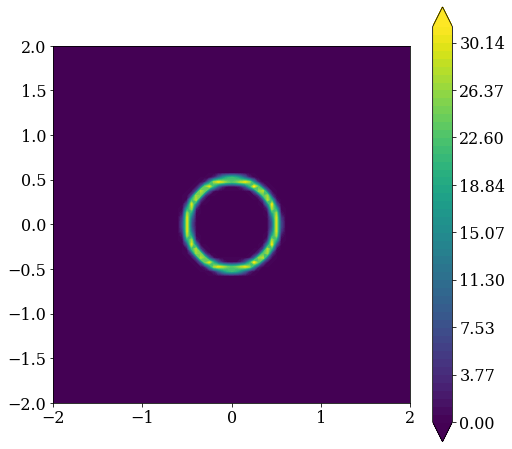

In [16]:
plot_contourf(fx.reshape(gridx.shape), gridx, body=None,
              axis_lim=(-2.0, 2.0, -2.0, 2.0),
              show_grid=False);

## Assemble LHS operator of velocity system

In [17]:
# Assemble the Laplacian operator.
LHat = pyibm.assemble_LHat(gridx, gridy)
pyibm.print_matrix_info(LHat, name='LHat')

# $L = \hat{M} \hat{L} R^{-1}$ (Taira & Colonius, 2007). 
L = MHat @ LHat @ RInv
pyibm.print_matrix_info(L, name='L (TC2007)')

Name:  LHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 75757)
Size:  377193
Symmetric:  False
Min/Max:  -1600.0000000000057 400.00000000000193
Name:  L (TC2007)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 75757)
Size:  377193
Symmetric:  True
Min/Max:  -9430.30712708833 4680.635036422563


In [18]:
# Assemble the implicit operator for the velocity system.
dt = 0.01  # time-step size
I = identity(gridx.size + gridy.size)
Re = 100.0  # Reynolds number
a_I = 0.5  # implicit coefficient of Crank-Nicolson scheme
AHat = 1 / dt * I - a_I / Re * LHat
pyibm.print_matrix_info(AHat, name='AHat')

# $A = \hat{M} \hat{A} R^{-1}$ (Taira & Colonius, 2007).
A = MHat @ AHat @ RInv
pyibm.print_matrix_info(A, name='A (TC2007)')

Name:  AHat
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 75757)
Size:  377193
Symmetric:  False
Min/Max:  -2.0000000000000098 108.00000000000003
Name:  A (TC2007)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 75757)
Size:  377193
Symmetric:  True
Min/Max:  -23.403175182112815 1217.3102947410819


In [19]:
# Check if A is SPD.
lambda_min ,lambda_max, cond = pyibm.condition_number(A)
print(lambda_min, lambda_max, cond)
lambda_min > 0

8.38544701963025 1263.8999811078786 150.72541489429258


True

## Assemble Poisson operator

In [20]:
N = 1  # order of Taylor series truncation
BN = pyibm.assemble_BN(gridx, gridy, dt=dt, N=N, L=L, M=M)
pyibm.print_matrix_info(BN, name=f'B{N}')
print('Condition number: ', pyibm.condition_number(BN))

Name:  B1
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (75757, 75757)
Size:  75757
Symmetric:  True
Min/Max:  0.01 0.01
Condition number:  (0.009999999999999998, 0.010000000000000002, 1.0000000000000004)


In [21]:
# Assemble QTBNQ as in Taira & Colonius (2007).
Q = hstack([G, E.T])
QTBNQ = Q.T @ BN @ Q
pyibm.print_matrix_info(QTBNQ, name='QTBNQ (TC2007)')
print('Condition number: ', pyibm.condition_number(QTBNQ))

Name:  QTBNQ (TC2007)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (38204, 38204)
Size:  193292
Symmetric:  True
Min/Max:  -0.07685268464407023 1.0000000000000144
Condition number:  (1.7903942593087948e-19, 2.0336518425851056, 1.1358681653560615e+19)


In [22]:
# Assemble Poisson operator.
DBNG = D @ BN @ G
pyibm.print_matrix_info(DBNG, name='DBNG')
print('Condition number: ', pyibm.condition_number(DBNG))

Name:  DBNG
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (38078, 38078)
Size:  189592
Symmetric:  True
Min/Max:  -0.04 0.01
Condition number:  (3.90219390027807e-19, -0.07999434733667048, -2.049983916252088e+17)


In [23]:
# Assemble Poisson operator as in decoupled IBPM of PetIBM.
DBNG = DHat @ BN @ GHat
pyibm.print_matrix_info(DBNG, name='DBNG (Hat)')
print('Condition number: ', pyibm.condition_number(DBNG))

Name:  DBNG (Hat)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (38078, 38078)
Size:  189592
Symmetric:  True
Min/Max:  -0.23947519459473085 0.11931030484998661
Condition number:  (-6.462275462665142e-20, -0.4772577006555944, 7.385288717772578e+18)


## LHS operator of system for forces

In [24]:
# Condition number when using E and H.
N_all = [1, 2, 3]
for N in N_all:
    print('\nExpansion order: ', N)
    BN = pyibm.assemble_BN(gridx, gridy, dt=dt, N=N, L=L, M=M)
    EBNH = E @ BN @ H
    pyibm.print_matrix_info(EBNH, name='EBNH')
    print('Condition number: ', pyibm.condition_number(EBNH))


Expansion order:  1
Name:  EBNH
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 126)
Size:  708
Symmetric:  True
Min/Max:  7.736119136478667e-10 0.0498458856606977
Condition number:  (0.0015676116595306935, 0.10099440370035118, 64.42565228851804)

Expansion order:  2
Name:  EBNH
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 126)
Size:  952
Symmetric:  True
Min/Max:  -0.17168095739990732 0.050684697873712985
Condition number:  (-0.01613312534232113, -0.24970445151569762, 15.477748186872496)

Expansion order:  3
Name:  EBNH
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 126)
Size:  1192
Symmetric:  True
Min/Max:  -0.38041806748164136 1.3395449207880148
Condition number:  (0.18750436375419088, 1.7598735584334961, 9.385773873191585)


Condition number not really changing at we use a high-order expansion of the approximate inverse.

In [25]:
# Condition number when using EHat and HHat.
N_all = [1, 2, 3]
for N in N_all:
    print('\nExpansion order: ', N)
    BN = pyibm.assemble_BN(gridx, gridy, dt=dt, N=N, L=LHat, M=MHat)
    EBNH = EHat @ BN @ HHat
    pyibm.print_matrix_info(EBNH, name='EBNH (Hat)')
    print('Condition number: ', pyibm.condition_number(EBNH))


Expansion order:  1
Name:  EBNH (Hat)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 126)
Size:  708
Symmetric:  True
Min/Max:  7.736119136478667e-10 0.04984588566069769
Condition number:  (0.0015676116595306937, 0.10099440370035104, 64.42565228851794)

Expansion order:  2
Name:  EBNH (Hat)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 126)
Size:  952
Symmetric:  True
Min/Max:  -88.56089133858104 20.272418358853084
Condition number:  (-7.086919615739594, -124.36908491196974, 17.549103370067012)

Expansion order:  3
Name:  EBNH (Hat)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 126)
Size:  1192
Symmetric:  False
Min/Max:  -3428.549704483995 12001.246134164761
Condition number:  (1623.3859336521868, 15870.258427668145, 9.776023124682546)


Again, no real change in the condition number.
So, what's the advantage of scaling `EHat` and `HHat`.

In [26]:
# Condition number of EBNH implemented in PetIBM.
# How is it affected by the Taylor expansion order?
N_all = [1, 2, 3]
for N in N_all:
    print('\nExpansion order: ', N)
    BN = pyibm.assemble_BN(gridx, gridy, dt=dt, N=N, L=LHat, M=MHat)
    EBNH = EHat2 @ BN @ HHat2
    pyibm.print_matrix_info(EBNH, name='EBNH (PetIBM)')
    print('Condition number: ', pyibm.condition_number(EBNH))


Expansion order:  1
Name:  EBNH (PetIBM)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 126)
Size:  708
Symmetric:  True
Min/Max:  1.552007559688825e-08 1.0000000000000093
Condition number:  (0.031449168547259626, 2.026133197588744, 64.42565228851797)

Expansion order:  2
Name:  EBNH (PetIBM)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 126)
Size:  952
Symmetric:  True
Min/Max:  -1776.6941075421637 406.7019391900899
Condition number:  (-142.17662143633112, -2495.072226393052, 17.549103370066955)

Expansion order:  3
Name:  EBNH (PetIBM)
Type:  <class 'scipy.sparse.csr.csr_matrix'>
Shape:  (126, 126)
Size:  1192
Symmetric:  False
Min/Max:  -68783.0030310275 240767.03573606233
Condition number:  (32568.102906278753, 318386.5271388207, 9.776023124682508)


The condition number of the operator `EBNH` is not significantly affected by the order of the Taylor expansion used to compute the inverse of the implicit velocity operator.